# Triaging time of the bugs in the pre-release when approaching its publishing date

In [13]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

from global_functions import *

In [14]:
from scipy import stats

def compare_distributions(tt,var1,var2,what): 
    
    normal_test_var1 = stats.kstest(tt[tt[what]==var1].fixing_time.values.tolist(), 'norm')
    normal_test_var2 = stats.kstest(tt[tt[what]==var2].fixing_time.values.tolist(), 'norm')
    
    #tt[[var1, var2]].plot(kind='box')
    
    #not normal distribution
    if normal_test_var1.pvalue<0.05 or  normal_test_var2.pvalue<0.05:
        print('At least one sample not normally distributed')
        #wilkoxon
        wresult = stats.ranksums(tt[tt[what]==var1].fixing_time, tt[tt[what]==var2].fixing_time)
        
        if wresult.pvalue<0.05:
            print('Statistically significant difference found for:'+var1)
        else:
            print('Statistically significant difference NOT found for:'+var1)
        print(wresult)
    else:
        print('Both samples are normally distributed')
        #t-test
        tresult = stats.ttest_rel(tt[tt[what]==var1].fixing_time, tt[tt[what]==var2].fixing_time)

        if tresult.pvalue<0.05:
            print('Statistically significant difference found for:'+var1)
        else:
            print('Statistically significant difference NOT found for:'+var1)
        print(tresult)
 

In [15]:
release_creation_ts_all = get_release_dates()

In [16]:
yearly_file = 'data'+os.sep+'bugs_info.zip'
df_monthly = pd.read_csv(yearly_file,index_col=False,compression='zip',
                                        dtype={'release': str})
df_monthly['release'] = df_monthly.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df_monthly.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaN,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,NaN,0.0,0.0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaN,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,NaN,0.0,0.0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaN,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,NaN,0.0,0.0,4.5,4.5,False,False


In [17]:
df_monthly.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [18]:
def get_monthly_fixing_stats(df_work,assignedFirst,fixedFirst):
    df_work = trans_to_datetime(df_work,['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date'])
    
    df_work['release'] = df_work['release'].astype(str)
    mon_stats = pd.DataFrame()
    
        
    if fixedFirst:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        

    for release in sorted(df_work.release.unique().tolist()):
        
        
        release = str(release)
        pred=predecessor(list(release_creation_ts_all.keys()),release)
        #print(release,pred)
        release_date = release_creation_ts_all[release]
        release_date = pd.to_datetime(release_date)

        dfw = df_work[df_work['release']==release]
        dfw = trans_to_datetime(dfw,['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])
        
        release_events = []
        release_events.append(dfw.creation_time.min())
        release_events.append(dfw[fix_column].min())
        end_inspection = min(release_events)
        
        month=-1
        while month <11:
            month+=1
            end_period = release_date-timedelta(30*month)
            if end_period < end_inspection:
                print('hi break')
                break
            start_period = release_date-timedelta(30*(month+1))
            
            bugs_assigned = (
                dfw[(dfw[fix_column]>=start_period)
                                 & 
                    (dfw[fix_column]<end_period)]
            )
            bugs_assigned = bugs_assigned[['id','release','Product','creation_time','last_fixed_date']].drop_duplicates()
            bugs_assigned['type'] = 'fixed'

            all_dfs = pd.DataFrame()
            all_dfs = all_dfs.append(bugs_assigned, ignore_index=True)
            all_dfs['start_period'] = start_period
            all_dfs['end_period'] = end_period
            all_dfs['month'] = month+1
            all_dfs['period'] = 'before'
            all_dfs['release'] = release
            #all_dfs['predecessor'] = str(pred)
            
            mon_stats = mon_stats.append(all_dfs,ignore_index=True)
        
    return mon_stats

In [19]:
e_target_file = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_last_fix_E_2.zip'
if not os.path.exists(e_target_file):
    df_monthly_stats_first = get_monthly_fixing_stats(df_monthly,assignedFirst=True,fixedFirst=False)
    df_monthly_stats_first.to_csv(e_target_file,index=False,compression='zip')
else:
    df_monthly_stats_first = pd.read_csv(e_target_file,index_col=False,compression='zip',
                                          dtype={'release': str,'predecessor': str})
    


In [20]:
df_monthly_stats_first['release'] = df_monthly_stats_first['release'].astype(str)
df_monthly_stats_first['month'] = df_monthly_stats_first.apply(lambda x : reverse_month(x['month']), axis=1)
#df_monthly_stats_first_2 = sort_df(df_monthly_stats_first_2,'release')
df_monthly_stats_first.head()

,id,release,Product,creation_time,last_fixed_date,type,start_period,end_period,month,period
0,64614,3.0,Platform,2004-05-28 19:29:59,2004-06-03 19:24:42,fixed,2004-05-26,2004-06-25,12,before
1,64617,3.0,Platform,2004-05-28 19:41:39,2004-06-09 10:40:47,fixed,2004-05-26,2004-06-25,12,before
2,64626,3.0,Platform,2004-05-28 19:57:21,2004-06-07 16:10:42,fixed,2004-05-26,2004-06-25,12,before
3,64627,3.0,Platform,2004-05-28 20:09:59,2004-06-08 02:17:03,fixed,2004-05-26,2004-06-25,12,before
4,64629,3.0,Platform,2004-05-28 20:19:41,2004-05-28 21:24:51,fixed,2004-05-26,2004-06-25,12,before


In [21]:
file_target_e = 'data'+os.sep+'RQ3'+os.sep+'time_fix_E_2.csv.gz'
if not os.path.exists(file_target_e):
    df_total=df_monthly_stats_first.copy()
    df_total = trans_to_datetime(df_total,['last_fixed_date','creation_time'])
    df_total['fixing_time'] =df_total.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
    df_total= df_total[['id','month','fixing_time' ,'release' ]]
    
    df_total.to_csv(file_target_e,index=False,compression='gzip')
else:
    df_total = pd.read_csv(file_target_e,index_col=False,compression='gzip',dtype={'release':str})
df_total.head()

,id,month,fixing_time,release
0,64614,12,5,3.0
1,64617,12,11,3.0
2,64626,12,9,3.0
3,64627,12,10,3.0
4,64629,12,0,3.0


3.0


C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


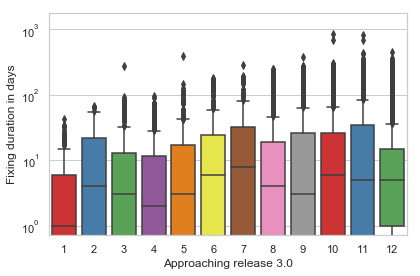

3.1


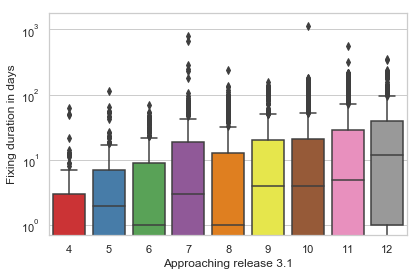

3.2


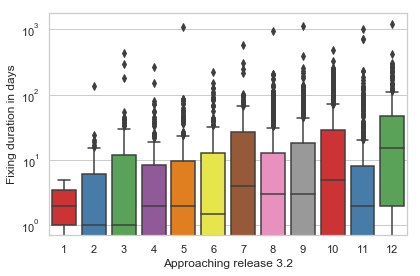

3.3


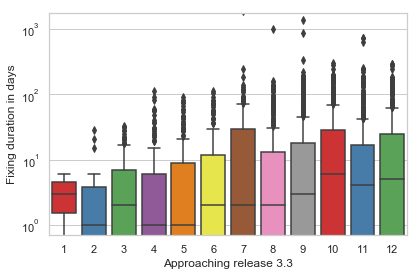

3.4


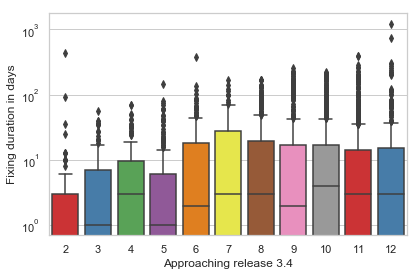

3.5


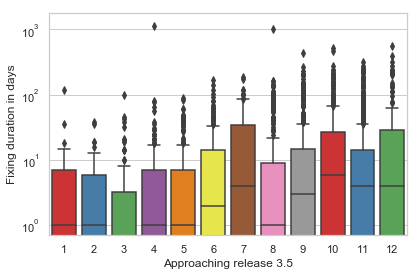

3.6


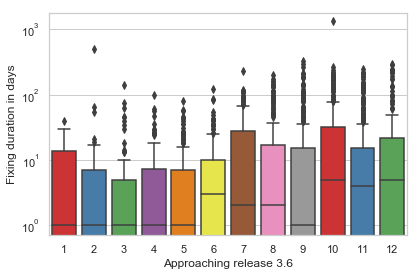

3.7


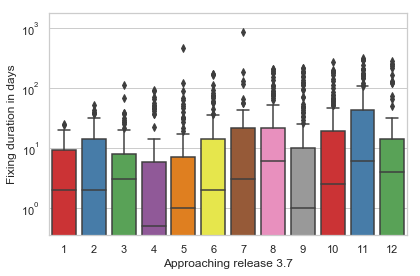

4.2


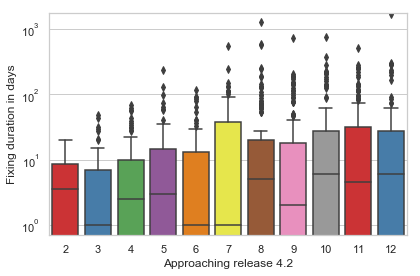

4.3


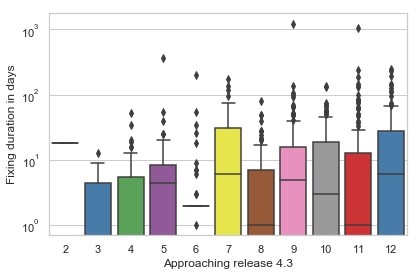

4.4


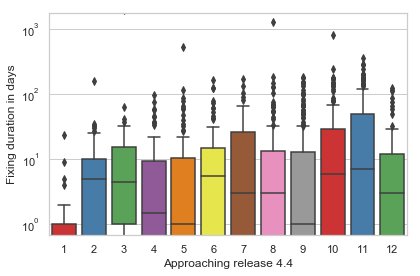

4.5


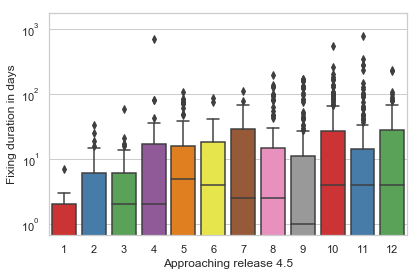

4.6


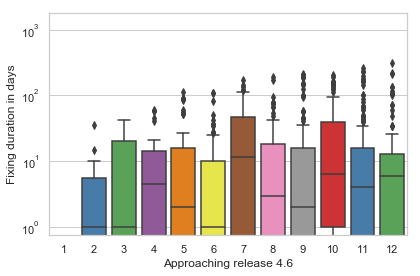

4.7


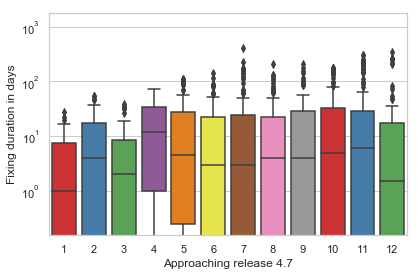

4.8


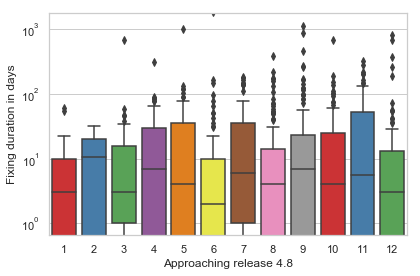

4.9


C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


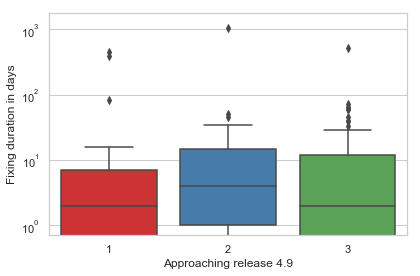

4.10


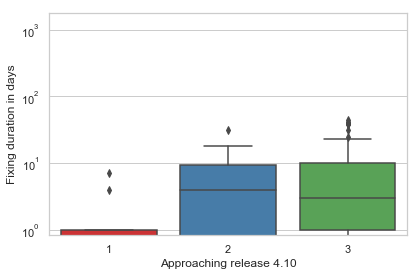

In [22]:
r_month=[10,11,12]

releases_only = df_total[['release']].drop_duplicates()
releases_only = sort_df(releases_only,'release')
releases_only = releases_only[['release']]

for release in releases_only.release.unique():
#release='4.3'
    release=str(release)
    if (release!='4.9') & (release!='4.10'):
        print(release)
        sns.set(style="whitegrid")
        draft=df_total[(df_total['release']==release) ]
        ax = plt.subplot(1, 1,1)
        
         
        sns.boxplot(x="month", y="fixing_time",
              data=draft, palette="Set1")
        ax.set_xlabel("Approaching release "+release)
        ax.set_ylabel("Fixing duration in days")
        ax.set_yscale('log')
        ax.set_ylim(0, 1800)
        
        plt.tight_layout( )
        plt.show()
        #ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'RQ3'+os.sep+'triagingRate_next'+release.replace('.', '-')+'.pdf', bbox_inches="tight")
        
    else:
        print(release)
        sns.set(style="whitegrid")
        draft=df_total[(df_total['release']==release) & (df_total['month'].isin(r_month))]
        ax = plt.subplot(1, 1,1)  
        sns.boxplot(x="month", y="fixing_time",
              data=draft, palette="Set1")
        ax.set_xlabel("Approaching release "+release)
        ax.set_ylabel("Fixing duration in days")
        ax.set_yscale('log')
        ax.set_ylim(0, 1800)
        ax.set_xticklabels( ('1', '2','3') )

        plt.tight_layout( )
        plt.show()
        #ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'RQ3'+os.sep+'triagingRate_next'+release.replace('.', '-')+'.pdf', bbox_inches="tight")            
#plt.savefig('rq3t4-4.pdf')